**features**:

num_stays: total number of unit stays

stay_length: total length of unit stays (use service mean stay length to impute)

stay_min: the min stay length of all admissions

stay_max: the max stay length of all admissions

stay_std: the std of stay length

stay_mean: the mean stay length

num_unique_services: number of unique services

num_transfer: number of admission transfers (different discharge and admission unit)

num_cvd_readmission: number of readmissions that are caused by cardiovascular

CVD: whether the patient has a cardiovescular diagnosis (0/1)

*Different Service name*: number of times they stay in this unit

*Different Specialty name*: number of times they stay in this specialty

*Different Age bins*: number of unit stays within this age range

age_mean: the mean admission age for each patient

age_std: the std of the admission age for each patient

age_min: the min age among all admissions

age_max: the max age among all admissions

freq: the frequency of admissions per year

readmission: whether this patient has ever been admitted again (0/1) (target)

died: whether this patient is dead or not (target)

AO: whether this patinet has been exposed to Agentorange

unique_admitting_specialty: (hasn't tidied the specialty)

unique_discharging_specialty: (hasn't tidied the specialty)

Age_min

Age_max

Stay_length: mean, std, min, max

We'll not consider location dataset anymore

In [1]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
datatype = "train"

In [3]:
if datatype == "train": 
    DATA_PATH = "../../../../bhatti/dataset/VCHAMPS"
    dataset_path = 'inpatient_admissions_train.csv'
elif datatype == "quality":
    DATA_PATH = '/data/public/MLA/VCHAMPS-Quality/'
    dataset_path = "inpatient_admissions_qual_Formatfixed.csv"
else: 
    DATA_PATH = '/data/public/MLA/VCHAMPS-Test/'
    dataset_path = "inpatient_admissions_test.csv"
load_path = os.path.join(DATA_PATH, dataset_path)
in_ad = pd.read_csv(load_path,index_col=0)
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,Discharge disposition,Died during admission,Outpatientreferralflag,Serviceconnectedflag,Agentorangeflag,State
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,Regular,No,No,NaN,Yes,Utah
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,Regular,No,Yes,No,No,North Carolina
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,Regular,No,No,NaN,No,North Carolina
3,10001,70.900369,2020-03-20 02:02:26.0,2020-03-28 08:47:01.0,SURGERY,SURGERY,PLASTIC SURGERY,SURGICAL STEPDOWN,Nonrheumatic mitral (valve) prolapse,Postprocedural shock,Regular,No,Yes,NaN,Yes,Florida
5,100016,83.054993,1999-11-20 14:23:45.0,1999-12-01 03:57:43.0,MEDICINE,MEDICINE,HEMATOLOGY/ONCOLOGY,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Unspecified mental disorder due to known physi...,Regular,No,No,NaN,NaN,Idaho
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665831,99965,93.433950,2022-07-21 02:36:19.0,2022-08-01 14:55:43.0,MEDICINE,MEDICINE,SUBST ABUSE CWT/TRANS RESID,GENERAL(ACUTE MEDICINE),Chronic or unspecified duodenal ulcer with hem...,Diastolic (congestive) heart failure,Regular,No,No,NaN,No,California
665832,99975,86.145532,2015-08-08 04:36:10.0,2015-08-17 03:26:06.0,MEDICINE,MEDICINE,Not specified,GENERAL(ACUTE MEDICINE),"Cutaneous abscess, furuncle and carbuncle of l...","Finding of other specified substances, not nor...",Regular,No,Yes,NaN,No,Minnesota
665833,99975,88.555516,2018-01-05 00:59:05.0,2018-01-06 23:18:39.0,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,"Umbilical hernia with obstruction, without gan...",Essential (primary) hypertension,Regular,No,No,NaN,No,Minnesota
665834,99986,73.435908,2019-06-26 19:47:10.0,2019-06-29 21:18:00.0,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),Cellulitis and acute lymphangitis of other par...,Other chronic osteomyelitis,Regular,No,Yes,NaN,No,Nevada


In [4]:
if datatype == "quality":
    in_ad.rename(columns = {'Age.at.admission': "Age at admission", "Admission.date": "Admission date", "Discharge.date": "Discharge date",
                            "Admitting.unit.service": "Admitting unit service", "Discharging.unit.service": "Discharging unit service",
                            "Admitting.specialty": "Admitting specialty", "Discharging.specialty": "Discharging specialty", 
                            "First.listed.discharge.diagnosis.icd10.subcategory": "First listed discharge diagnosis icd10 subcategory",
                            "Second.listed.discharge.diagnosis.icd10.subcategory": "First listed discharge diagnosis icd10 subcategory",
                            "Discharge.disposition": "Discharge disposition", "Died.during.admission": "Died during admission"}, inplace = True)

### Died at location

In [5]:
in_ad["Died during admission"] = in_ad["Died during admission"].replace({"Yes":1, "No": 0})
in_ad["Agentorangeflag"] = in_ad["Agentorangeflag"].replace({"Yes":1, "No": 0})

### Num transfers

In [6]:
in_ad['Transfer'] = [0] * len(in_ad)
def transfer(data):
    data.loc[data['Admitting unit service'] != data['Discharging unit service'], 'Transfer'] = 1
    return data
in_ad = transfer(in_ad)

### Regrouping Admitting Unit Serivice

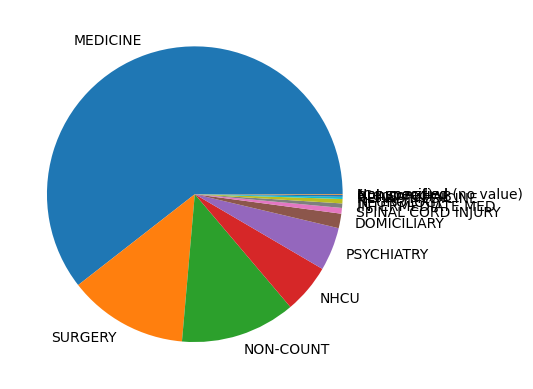

In [7]:
plt.pie(in_ad["Admitting unit service"].value_counts(), labels = in_ad["Admitting unit service"].value_counts().index);

In [8]:
in_ad["Admitting unit service"].unique()

array(['NON-COUNT', 'MEDICINE', 'SURGERY', 'NHCU', 'PSYCHIATRY',
       'REHAB MEDICINE', 'INTERMEDIATE MED', 'NEUROLOGY', 'DOMICILIARY',
       'BLIND REHAB', '(Censored)', 'SPINAL CORD INJURY',
       'Not specified (no value)', 'Not specified'], dtype=object)

In [9]:
in_ad["Admitting unit service"] = in_ad["Admitting unit service"].replace({'REHAB MEDICINE':'OTHERS', 'BLIND REHAB':'OTHERS',
                                        '(Censored)':'NON-COUNT', 'Not specified (no value)':'NON-COUNT', 'Not specified':'NON-COUNT',
                                        'INTERMEDIATE MED':'OTHERS', 'NEUROLOGY':'OTHERS', 'SPINAL CORD INJURY':'OTHERS'})
in_ad = pd.concat([in_ad, pd.get_dummies(in_ad['Admitting unit service'])], axis=1)

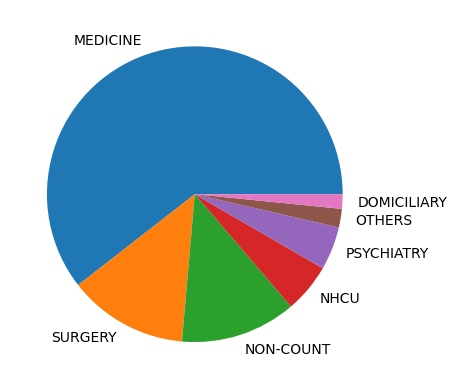

In [10]:
plt.pie(in_ad["Admitting unit service"].value_counts(), labels = in_ad["Admitting unit service"].value_counts().index);

### Length of Stay

In [11]:
admission_stay_length = []
for i, row in in_ad.iterrows():
    start = row["Admission date"]
    end = row["Discharge date"]

    start = pd.to_datetime(start,
               format='%Y-%m-%d %H:%M:%S.%f')
    end = pd.to_datetime(end,
               format='%Y-%m-%d %H:%M:%S.%f')
    
    diff = pd.Timedelta(end - start).days
    diff += round(pd.Timedelta(end - start).seconds/3600/24,2)

    admission_stay_length.append(diff)

in_ad["stay_length"] = admission_stay_length # in terms of day

#### Imputation

In [12]:
mean_stay_length = in_ad.groupby("Admitting unit service")["stay_length"].mean()
nan_admission = in_ad[in_ad["stay_length"].isna()]
in_ad = in_ad[~in_ad["stay_length"].isna()]

In [13]:
admission_stay_length = []
for i, row in nan_admission.iterrows():
    service = row["Admitting unit service"]
    diff = mean_stay_length[service]

    admission_stay_length.append(round(diff,2))

nan_admission["stay_length"] = admission_stay_length

In [14]:
in_ad = pd.concat([in_ad, nan_admission])
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,State,Transfer,DOMICILIARY,MEDICINE,NHCU,NON-COUNT,OTHERS,PSYCHIATRY,SURGERY,stay_length
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,...,Utah,0,0,0,0,1,0,0,0,0.33
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,...,North Carolina,0,0,1,0,0,0,0,0,2.81
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,...,North Carolina,0,0,0,0,0,0,0,1,9.18
3,10001,70.900369,2020-03-20 02:02:26.0,2020-03-28 08:47:01.0,SURGERY,SURGERY,PLASTIC SURGERY,SURGICAL STEPDOWN,Nonrheumatic mitral (valve) prolapse,Postprocedural shock,...,Florida,0,0,0,0,0,0,0,1,8.28
5,100016,83.054993,1999-11-20 14:23:45.0,1999-12-01 03:57:43.0,MEDICINE,MEDICINE,HEMATOLOGY/ONCOLOGY,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Unspecified mental disorder due to known physi...,...,Idaho,0,0,1,0,0,0,0,0,10.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656612,78051,78.979333,2016-10-20 22:42:41.0,NaN,NHCU,NHCU,"PULMONARY, NON-TB",NH LONG-STAY CONTINUING CARE,(Censored),"Urinary tract infection, site not specified",...,Texas,0,0,0,1,0,0,0,0,98.51
657425,88349,74.120852,2025-04-06 04:06:43.0,NaN,MEDICINE,MEDICINE,GENERAL SURGERY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,Nevada,0,0,1,0,0,0,0,0,5.86
663273,96010,81.459315,2020-10-08 09:06:47.0,NaN,OTHERS,SPINAL CORD INJURY,PTSD RESID REHAB PROG,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,Ohio,0,0,0,0,0,1,0,0,23.12
665052,96702,63.414981,2023-10-01 04:12:48.0,NaN,MEDICINE,MEDICINE,DOMICILIARY PTSD,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,Rhode Island,0,0,1,0,0,0,0,0,5.86


### Age at admission

Divide to different age bins: (20-40], (40-60], (60-80], (80-100], (100-120]

In [15]:
print(in_ad["Age at admission"].min())
print(in_ad["Age at admission"].max())

20.39913281527081
109.22492751557988


In [16]:
in_ad['Age 20-40'] = [0] * len(in_ad)
in_ad['Age 40-60'] = [0] * len(in_ad)
in_ad['Age 60-80'] = [0] * len(in_ad)
in_ad['Age 80-100'] = [0] * len(in_ad)
in_ad['Age 100-120'] = [0] * len(in_ad)
def age_category(data):
    data.loc[(data['Age at admission'] > 20) & (data['Age at admission'] <= 40), 'Age 20-40'] = 1
    data.loc[(data['Age at admission'] > 40) & (data['Age at admission'] <= 60), 'Age 40-60'] = 1
    data.loc[(data['Age at admission'] > 60) & (data['Age at admission'] <= 80), 'Age 60-80'] = 1
    data.loc[(data['Age at admission'] > 80) & (data['Age at admission'] <= 100), 'Age 80-100'] = 1
    data.loc[(data['Age at admission'] > 100) & (data['Age at admission'] <= 120), 'Age 100-120'] = 1
    return data
in_ad = age_category(in_ad)
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,NON-COUNT,OTHERS,PSYCHIATRY,SURGERY,stay_length,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,...,1,0,0,0,0.33,0,0,1,0,0
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,...,0,0,0,0,2.81,0,0,0,1,0
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,...,0,0,0,1,9.18,0,0,0,1,0
3,10001,70.900369,2020-03-20 02:02:26.0,2020-03-28 08:47:01.0,SURGERY,SURGERY,PLASTIC SURGERY,SURGICAL STEPDOWN,Nonrheumatic mitral (valve) prolapse,Postprocedural shock,...,0,0,0,1,8.28,0,0,1,0,0
5,100016,83.054993,1999-11-20 14:23:45.0,1999-12-01 03:57:43.0,MEDICINE,MEDICINE,HEMATOLOGY/ONCOLOGY,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Unspecified mental disorder due to known physi...,...,0,0,0,0,10.57,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656612,78051,78.979333,2016-10-20 22:42:41.0,NaN,NHCU,NHCU,"PULMONARY, NON-TB",NH LONG-STAY CONTINUING CARE,(Censored),"Urinary tract infection, site not specified",...,0,0,0,0,98.51,0,0,1,0,0
657425,88349,74.120852,2025-04-06 04:06:43.0,NaN,MEDICINE,MEDICINE,GENERAL SURGERY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,0,0,5.86,0,0,1,0,0
663273,96010,81.459315,2020-10-08 09:06:47.0,NaN,OTHERS,SPINAL CORD INJURY,PTSD RESID REHAB PROG,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,1,0,0,23.12,0,0,0,1,0
665052,96702,63.414981,2023-10-01 04:12:48.0,NaN,MEDICINE,MEDICINE,DOMICILIARY PTSD,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,0,0,5.86,0,0,1,0,0


### Cardiovascular

In [17]:
cardiovascular = ["Heart failure, unspecified", "Other heart failure",
                  "Cardiogenic shock", "Hypertensive heart disease with heart failure",
                  "Hypertensive heart and kidney disease with heart failure", "Unstable angina", "Other forms of chronic ischemic heart disease",
                  "Atherosclerotic heart disease of native coronary artery", "Atrial fibrillation", "Atrial flutter",
                  "Supraventricular tachycardia", "Ventricular tachycardia"]

In [18]:
in_ad["cd_diagnosis"] = [0] * len(in_ad)
def cd_diagnosis(data):
    data.loc[(in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)), "cd_diagnosis"] = 1
    return data
in_ad = cd_diagnosis(in_ad)
in_ad


,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,OTHERS,PSYCHIATRY,SURGERY,stay_length,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120,cd_diagnosis
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,...,0,0,0,0.33,0,0,1,0,0,0
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,...,0,0,0,2.81,0,0,0,1,0,0
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,...,0,0,1,9.18,0,0,0,1,0,0
3,10001,70.900369,2020-03-20 02:02:26.0,2020-03-28 08:47:01.0,SURGERY,SURGERY,PLASTIC SURGERY,SURGICAL STEPDOWN,Nonrheumatic mitral (valve) prolapse,Postprocedural shock,...,0,0,1,8.28,0,0,1,0,0,0
5,100016,83.054993,1999-11-20 14:23:45.0,1999-12-01 03:57:43.0,MEDICINE,MEDICINE,HEMATOLOGY/ONCOLOGY,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Unspecified mental disorder due to known physi...,...,0,0,0,10.57,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656612,78051,78.979333,2016-10-20 22:42:41.0,NaN,NHCU,NHCU,"PULMONARY, NON-TB",NH LONG-STAY CONTINUING CARE,(Censored),"Urinary tract infection, site not specified",...,0,0,0,98.51,0,0,1,0,0,0
657425,88349,74.120852,2025-04-06 04:06:43.0,NaN,MEDICINE,MEDICINE,GENERAL SURGERY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,0,5.86,0,0,1,0,0,0
663273,96010,81.459315,2020-10-08 09:06:47.0,NaN,OTHERS,SPINAL CORD INJURY,PTSD RESID REHAB PROG,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,1,0,0,23.12,0,0,0,1,0,0
665052,96702,63.414981,2023-10-01 04:12:48.0,NaN,MEDICINE,MEDICINE,DOMICILIARY PTSD,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,0,5.86,0,0,1,0,0,0


In [19]:
in_ad.columns

Index(['Internalpatientid', 'Age at admission', 'Admission date',
       'Discharge date', 'Admitting unit service', 'Discharging unit service',
       'Admitting specialty', 'Discharging specialty',
       'First listed discharge diagnosis icd10 subcategory',
       'Second listed discharge diagnosis icd10 subcategory',
       'Discharge disposition', 'Died during admission',
       'Outpatientreferralflag', 'Serviceconnectedflag', 'Agentorangeflag',
       'State', 'Transfer', 'DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT',
       'OTHERS', 'PSYCHIATRY', 'SURGERY', 'stay_length', 'Age 20-40',
       'Age 40-60', 'Age 60-80', 'Age 80-100', 'Age 100-120', 'cd_diagnosis'],
      dtype='object')

### Specialty

In [20]:
sub_abuse_and_mental = ['DRUG DEPENDENCE TRMT UNIT', 'PSYCHIATRIC MENTALLY INFIRM', 'SUBSTANCE ABUSE RES TRMT PROG', 'PLASTIC SURGERY', 'PSYCH RESID REHAB TRMT PROG', 'SUBSTANCE ABUSE INTERMED CARE', 'ACUTE PSYCHIATRY (<45 DAYS)', 'DOMICILIARY PTSD', 
                        'ALCOHOL DEPENDENCE TRMT UNIT', 'EVAL/BRF TRMT PTSD UNIT(EBTPU)', 'PTSD RESID REHAB PROG', 'PSYCH RESID REHAB PROG', 'PTSD CWT/TR', 
                        'PTSD RESIDENTIAL REHAB PROG', 'SUBST ABUSE STAR I, II & III', 'SUBSTANCE ABUSE TRMT UNIT', 'GEN INTERMEDIATE PSYCH', 'LONG TERM PSYCHIATRY(>45 DAYS)', 'SUBSTANCE ABUSE RESID PROG', 
                        'DOMICILIARY SUBSTANCE ABUSE', 'SIPU (SPEC INPT PTSD UNIT)', 'ZZALCOHOL DEPENDENCE TRMT UNIT', 'ZZSUBSTANCE ABUSE INTERMEDCARE', 'PSYCHIATRY', 'ZZDRUG DEPENDENCE TRMT UNIT',
                        'ZZSUBSTANCE ABUSE TRMT UNIT', 'GEN MEDICINE (ACUTE)', 'zSUBST ABUSE STAR I, II & III', 'ZZSUBST ABUSE STAR I,II,II', 'SUBST ABUSE CWT/TRANS RESID', 'HIGH INTENSITY GEN PSYCH INPAT', 'HALFWAY HOUSE']
medical = ['HEMATOLOGY/ONCOLOGY', 'GASTROENTEROLOGY', 'INTERMEDIATE MEDICINE', 'ANESTHESIOLOGY', 'PROCTOLOGY', 'CARDIAC SURGERY', 'TRANSPLANTATION', 'CARDIOLOGY', 'METABOLIC',
           'GENERAL(ACUTE MEDICINE)', 'PEDIATRICS', 'VASCULAR', 'OPHTHALMOLOGY', 'NEUROSURGERY', 'SURGICAL STEPDOWN', 'UROLOGY', 'PULMONARY, TUBERCULOSIS', 'PERIPHERAL VASCULAR', 
           'THORACIC SURGERY', 'MEDICAL STEP DOWN', 'GENERAL SURGERY', 'PULMONARY, NON-TB', 'EPILEPSY CENTER', 'NEUROLOGY', 'SPINAL CORD INJURY', 'ORAL SURGERY',
           'PODIATRY', 'EAR, NOSE, THROAT (ENT)', 'ENDOCRINOLOGY', 'CARDIAC-STEP DOWN UNIT', 'TELEMETRY', 'OB/GYN', 'ORTHOPEDIC', 'DOMICILIARY','ALLERGY', 'STROKE UNIT', 'DERMATOLOGY',
           'CARDIAC INTENSIVE CARE UNIT', 'HOSPICE FOR ACUTE CARE', 'SURGICAL ICU', 'MEDICAL ICU']
rehab = ['NH SHORT STAY REHABILITATION', 'BLIND REHAB OBSERVATION', 'BLIND REHAB', 'NH LONG STAY DEMENTIA CARE', 'NH SHORT-STAY CONTINUING CARE', 'NH HOSPICE', 'NEUROLOGY OBSERVATION', 'NH LONG-STAY MH RECOVERY', 
         'NH SHORT-STAY MH RECOVERY', 'NH SHORT STAY RESTORATIVE', 'REHABILITATION MEDICINE','NH SHORT STAY DEMENTIA CARE', 'RESPITE CARE (MEDICINE)', 'PM&R TRANSITIONAL REHAB', 
         'SPINAL CORD INJURY OBSERVATION', 'POLYTRAUMA REHAB UNIT', 'SURGICAL OBSERVATION', 'NHCU', 'NH SHORT STAY SKILLED NURSING', 'NH GEM NURSING HOME CARE', 'NH LONG STAY SKILLED NURSING', 'NH LONG-STAY CONTINUING CARE', 'ED OBSERVATION', 
         'MEDICAL OBSERVATION', 'REHAB MEDICINE OBSERVATION', 'PSYCHIATRIC OBSERVATION', 'NH LONG STAY SPINAL CORD INJ', 'DOD BEDS IN VA FACILITY', 'NON-DOD BEDS IN VA FACILITY', 'GENERAL CWT/TR', 'HOMELESS CWT/TRANS RESID', 'PRRTP', 'HIGH INTENSITY GEN INPT',
         'DOMICILIARY CHV', 'STAR I, II & III']
gem = ['GRECC-MED', 'SHORT STAY GRECC-GEM-NHCU', 'GEM DOMICILIARY', 'SHORT STAY GRECC-NHCU', 'GEM REHABILITATION MEDICINE', 'GRECC-GEM-REHAB', 'GEM NEUROLOGY', 
       'GEM ACUTE MEDICINE', 'LONG STAY GRECC-NHCU', 'GEM PSYCHIATRIC BEDS', 'GERONTOLOGY', 'GEM INTERMEDIATE CARE']
others = ['Not specified', '(Censored)', 'Not specified (no value)']

In [21]:
in_ad['Mental'] = [0] * len(in_ad)
in_ad['Medical'] = [0] * len(in_ad)
in_ad['Rehab'] = [0] * len(in_ad)
in_ad['Gerontology'] = [0] * len(in_ad)
in_ad['Others_Specialty'] = [0] * len(in_ad)
def age_category(data):
    data.loc[(data['Admitting specialty'].isin(sub_abuse_and_mental)), 'Mental'] = 1
    data.loc[(data['Admitting specialty'].isin(medical)), 'Medical'] = 1
    data.loc[(data['Admitting specialty'].isin(rehab)), 'Rehab'] = 1
    data.loc[(data['Admitting specialty'].isin(gem)), 'Gerontology'] = 1
    data.loc[(data['Admitting specialty'].isin(others)), 'Others_Specialty'] = 1
    return data
in_ad = age_category(in_ad)
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,...,Age 40-60,Age 60-80,Age 80-100,Age 100-120,cd_diagnosis,Mental,Medical,Rehab,Gerontology,Others_Specialty
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,...,0,1,0,0,0,1,0,0,0,0
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,...,0,0,1,0,0,1,0,0,0,0
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,...,0,0,1,0,0,1,0,0,0,0
3,10001,70.900369,2020-03-20 02:02:26.0,2020-03-28 08:47:01.0,SURGERY,SURGERY,PLASTIC SURGERY,SURGICAL STEPDOWN,Nonrheumatic mitral (valve) prolapse,Postprocedural shock,...,0,1,0,0,0,1,0,0,0,0
5,100016,83.054993,1999-11-20 14:23:45.0,1999-12-01 03:57:43.0,MEDICINE,MEDICINE,HEMATOLOGY/ONCOLOGY,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Unspecified mental disorder due to known physi...,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656612,78051,78.979333,2016-10-20 22:42:41.0,NaN,NHCU,NHCU,"PULMONARY, NON-TB",NH LONG-STAY CONTINUING CARE,(Censored),"Urinary tract infection, site not specified",...,0,1,0,0,0,0,1,0,0,0
657425,88349,74.120852,2025-04-06 04:06:43.0,NaN,MEDICINE,MEDICINE,GENERAL SURGERY,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,1,0,0,0,0,1,0,0,0
663273,96010,81.459315,2020-10-08 09:06:47.0,NaN,OTHERS,SPINAL CORD INJURY,PTSD RESID REHAB PROG,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,0,1,0,0,1,0,0,0,0
665052,96702,63.414981,2023-10-01 04:12:48.0,NaN,MEDICINE,MEDICINE,DOMICILIARY PTSD,GENERAL(ACUTE MEDICINE),Not specified,Not specified,...,0,1,0,0,0,1,0,0,0,0


### Agentorange Imputation

In [22]:
len(in_ad[in_ad["Agentorangeflag"].isna()])/len(in_ad)

0.199931132111566

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

no_na = in_ad[in_ad['Agentorangeflag'].notna()]
only_na = in_ad[in_ad['Agentorangeflag'].isna()]

zero=no_na[no_na.Agentorangeflag==0]
one=no_na[no_na.Agentorangeflag==1]

#upsample minority
Agentorange_upsampled = resample(one,
                          replace=True, # sample with replacement
                          n_samples=len(zero), # match number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([zero, Agentorange_upsampled])

# use upsampled data to train the model
X = upsampled[['Age at admission', 'Transfer', 'stay_length', 'cd_diagnosis','DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT',
       'OTHERS', 'PSYCHIATRY', 'SURGERY','Medical', 'Mental', 'Others_Specialty', 'Rehab', 'Gerontology']].values
Y = upsampled['Agentorangeflag'].values


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

ACCURACY: TRAIN=0.8732 TEST=0.8416
LOG LOSS: 0.3823492624624285


In [24]:
only_na = only_na[['Age at admission', 'Transfer', 'stay_length', 'cd_diagnosis','DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT',
       'OTHERS', 'PSYCHIATRY', 'SURGERY','Medical', 'Mental', 'Others_Specialty', 'Rehab', 'Gerontology']]
prediction = forest.predict(only_na)
only_na = in_ad[in_ad['Agentorangeflag'].isna()].drop('Agentorangeflag', axis=1)
only_na['Agentorangeflag'] = prediction

in_ad = [only_na, no_na]
in_ad = pd.concat(in_ad)

/home/hassan/.conda/envs/mla/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [25]:
if datatype == "train": in_ad.to_csv("in_ad.csv")

### Final dataset

In [26]:
if datatype == "train": 
    datapath = "/home/bhatti/dataset/VCHAMPS/death_train.csv"
    death = pd.read_csv(datapath, index_col=0)
elif datatype == "test":
    datapath = "/data/public/MLA/VCHAMPS-Test/death_test.csv"
    death = pd.read_csv(datapath, index_col=0)

In [27]:
def final_set_before(ids, group):
    
    readmission = 0
    num_admissions = group["Age at admission"].nunique()
    if num_admissions > 1: readmission=1

    age_mean = group["Age at admission"].mean()
    age_std = group["Age at admission"].std()
    if group["Age at admission"].nunique() == 1: age_std = 0

    min_age = group["Age at admission"].min()
    max_age = group["Age at admission"].max()

    freq = num_admissions/(math.floor(max_age - min_age) + 1)

    min_stay = group["stay_length"].min()
    max_stay = group["stay_length"].min()
    stay_mean = group["stay_length"].mean()
    stay_std = group["stay_length"].std()
    if group["stay_length"].nunique() == 1: stay_std = 0

    # num_cvd_readmission = max(0, group['cd_diagnosis'].sum() - 1)
    num_cvd_admission = group['cd_diagnosis'].sum()

    cvd = 0
    if group["cd_diagnosis"].sum() > 0: cvd = 1
    
    Died = 0
    if group["Died during admission"].sum() > 0: Died = 1

    AO = 0
    if group["Agentorangeflag"].sum() > 0: AO = 1

    df = pd.DataFrame(data={'Internalpatientid': [ids], 'num_stays': [num_admissions], 'stay_length': group["stay_length"].sum(),
                            'num_unique_units': group["Admitting unit service"].nunique(), "num_transfers": group["Transfer"].sum(), 
                            "num_cvd_admission": [num_cvd_admission], "Died": [Died], "AO": [AO], "CVD": [cvd],
                            "unique_admitting_specialty": group["Admitting specialty"].nunique(), "unique_discharging_specialty": group["Discharging specialty"].nunique(),
                            "DOMICILIARY": group["DOMICILIARY"].sum(), "MEDICINE": group["MEDICINE"].sum(), "NHCU":group["NHCU"].sum(),
                            "NON-COUNT":group["NON-COUNT"].sum(), "OTHERS":group["OTHERS"].sum(), 'PSYCHIATRY': group['PSYCHIATRY'].sum(), 'SURGERY': group['SURGERY'].sum(),
                            'Age 20-40': group["Age 20-40"].sum(), 'Age 40-60': group["Age 40-60"].sum(), 'Age 60-80':group["Age 60-80"].sum(), 
                            'Age 80-100':group["Age 80-100"].sum(), 'Age 100-120':group["Age 100-120"].sum(), "age_mean": [age_mean], "age_std": [age_std], 
                            "age_min": [min_age], "age_max": [max_age], "stay_min": [min_stay], "stay_max": [max_stay], "stay_mean": [stay_mean],
                            "stay_std": [stay_std], "freq": [round(freq,2)], 'Medical': group["Medical"].sum(), 'Mental':group["Mental"].sum(), 
                            'Others_Specialty':group["Others_Specialty"].sum(), 'Rehab': group["Rehab"].sum(), 'Gerontology': group["Gerontology"].sum()
                            })
    df = df.reset_index(drop=True)
    return df

In [36]:
def final_set(ids, group):
    full = []
    ddl = 0
    for i in range(len(group)):
        if ((i+1) != (len(group) - 1)) and (len(group) != 1): 
            # for now we only consider the case when the last row is used as the indicator
            continue
        df = final_set_before(ids, group.iloc[0:i+1,])
        
        CVD_readmission = 0

        if len(group) == i+1: 
            read_time = 0
            ddl = group.iloc[i]["Discharge date"]
        else: 
            start = group.iloc[i]["Discharge date"]
            end = group.iloc[i+1]["Admission date"]
            ddl = start

            start = pd.to_datetime(start,
               format='%Y-%m-%d %H:%M:%S.%f')
            end = pd.to_datetime(end,
               format='%Y-%m-%d %H:%M:%S.%f')
            read_time = pd.Timedelta(end - start).days
            read_time += round(pd.Timedelta(end - start).seconds/3600/24,2)

            if df["num_cvd_admission"].item() > 0:
                # if this patient once admitted due to CVD
                if group.iloc[i+1]["cd_diagnosis"] == 1:
                    # if the indicator admission also caused by CVD
                    CVD_readmission = 1

        df["CVD_readmission"] = CVD_readmission
        df["next_readmission_time"] = read_time
        df["Discharge date"] = ddl
        # if read_time < 0: print(group[["Admission date","Discharge date"]])

        if (read_time > 300) or (read_time == 0): threshold = 0
        else: threshold = 1
        df["readmission within 300 days"] = threshold
        full.append(df)
    return pd.concat(full)

In [37]:
tidy_dataset = []
for ids, group in tqdm(in_ad.groupby("Internalpatientid")):
    group = group.sort_values(by = ['Admission date'],ascending=True).reset_index(drop = True)
    
    df = final_set(ids, group)
    tidy_dataset.append(df)
    
tidy_dataset = pd.concat(tidy_dataset)

  0%|          | 0/84536 [00:00<?, ?it/s]

In [38]:
tidy_dataset

,Internalpatientid,num_stays,stay_length,num_unique_units,num_transfers,num_cvd_admission,Died,AO,CVD,unique_admitting_specialty,...,freq,Medical,Mental,Others_Specialty,Rehab,Gerontology,CVD_readmission,next_readmission_time,Discharge date,readmission within 300 days
0,1,3,14.16,2,0,0,0,0,0,3,...,0.60,3,0,0,0,0,0,2352.34,2016-07-22 21:36:24.0,0
0,2,21,71.17,5,2,10,0,0,1,9,...,1.50,10,1,0,9,1,1,0.00,2023-09-12 02:28:10.0,0
0,3,1,1.83,1,0,1,0,0,1,1,...,1.00,0,0,0,1,0,0,885.57,2002-03-30 18:12:14.0,0
0,4,1,7.15,1,0,1,0,0,1,1,...,1.00,0,0,0,1,0,0,0.00,2015-02-23 09:46:15.0,0
0,5,1,1.04,1,0,1,0,0,1,1,...,1.00,1,0,0,0,0,0,26.75,2004-10-02 06:54:56.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,169055,1,6.47,1,0,1,0,0,1,1,...,1.00,0,1,0,0,0,0,0.00,2002-04-12 16:51:53.0,0
0,169057,28,94.63,3,2,13,0,0,1,11,...,2.15,3,0,0,13,12,1,2.21,2025-02-12 17:23:04.0,1
0,169060,7,41.68,2,0,5,0,0,1,5,...,0.47,4,1,0,1,1,1,51.81,2017-02-08 09:55:03.0,1
0,169062,11,135.67,4,0,0,0,1,0,6,...,2.75,9,2,0,0,0,0,89.89,2005-06-04 03:34:07.0,1


In [39]:
tidy_dataset.columns

Index(['Internalpatientid', 'num_stays', 'stay_length', 'num_unique_units',
       'num_transfers', 'num_cvd_admission', 'Died', 'AO', 'CVD',
       'unique_admitting_specialty', 'unique_discharging_specialty',
       'DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT', 'OTHERS', 'PSYCHIATRY',
       'SURGERY', 'Age 20-40', 'Age 40-60', 'Age 60-80', 'Age 80-100',
       'Age 100-120', 'age_mean', 'age_std', 'age_min', 'age_max', 'stay_min',
       'stay_max', 'stay_mean', 'stay_std', 'freq', 'Medical', 'Mental',
       'Others_Specialty', 'Rehab', 'Gerontology', 'CVD_readmission',
       'next_readmission_time', 'Discharge date',
       'readmission within 300 days'],
      dtype='object')

In [40]:
if datatype == "train": tidy_dataset.to_csv("inpatient_full_simple.csv")
if datatype == "quality": tidy_dataset.to_csv("inpatient_simple_quality.csv")
if datatype == "test": tidy_dataset.to_csv("inpatient_simple_test.csv")

### Add death indicator (for inpatient only dataset, we don't run this part for now)

In [29]:
# tidy_dataset = pd.read_csv("inpatient_full_simple.csv", index_col=0)
tidy_dataset = tidy_dataset.merge(death, how="left",on="Internalpatientid")

In [30]:
tidy_dataset.columns

Index(['Internalpatientid', 'num_stays', 'stay_length', 'num_unique_units',
       'num_transfers', 'num_cvd_readmission', 'Died', 'AO', 'CVD',
       'unique_admitting_specialty', 'unique_discharging_specialty',
       'DOMICILIARY', 'MEDICINE', 'NHCU', 'NON-COUNT', 'OTHERS', 'PSYCHIATRY',
       'SURGERY', 'Age 20-40', 'Age 40-60', 'Age 60-80', 'Age 80-100',
       'Age 100-120', 'age_mean', 'age_std', 'age_min', 'age_max', 'stay_min',
       'stay_max', 'stay_mean', 'stay_std', 'freq', 'Medical', 'Mental',
       'Others_Specialty', 'Rehab', 'Gerontology', 'next_readmission_time',
       'Discharge date', 'readmission within 300 days', 'Age at death',
       'Death date'],
      dtype='object')

In [31]:
tidy_dataset['Discharge date'] = pd.to_datetime(tidy_dataset['Discharge date'])
tidy_dataset['Death date'] = pd.to_datetime(tidy_dataset['Death date'])
tidy_dataset["away_from_death"] = (tidy_dataset['Death date'] - tidy_dataset['Discharge date']).dt.days
tidy_dataset

,Internalpatientid,num_stays,stay_length,num_unique_units,num_transfers,num_cvd_readmission,Died,AO,CVD,unique_admitting_specialty,...,Mental,Others_Specialty,Rehab,Gerontology,next_readmission_time,Discharge date,readmission within 300 days,Age at death,Death date,away_from_death
0,1,3,14.16,2,0,0,0,0,0,3,...,0,0,0,0,2352.34,2016-07-22 21:36:24,0,NaN,NaT,NaN
1,2,21,71.17,5,2,9,0,0,1,9,...,1,0,9,1,0.00,2023-09-12 02:28:10,0,NaN,NaT,NaN
2,3,1,1.83,1,0,0,0,0,1,1,...,0,0,1,0,885.57,2002-03-30 18:12:14,0,82.284691,2005-10-12 01:18:21,1291.0
3,4,1,7.15,1,0,0,0,0,1,1,...,0,0,1,0,0.00,2015-02-23 09:46:15,0,84.190359,2015-02-24 13:49:53,1.0
4,5,1,1.04,1,0,0,0,0,1,1,...,0,0,0,0,26.75,2004-10-02 06:54:56,1,76.506124,2004-11-04 23:43:20,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84531,169055,1,6.47,1,0,0,0,0,1,1,...,1,0,0,0,0.00,2002-04-12 16:51:53,0,68.572433,2011-12-06 05:22:50,3524.0
84532,169057,28,94.63,3,2,12,0,0,1,11,...,0,0,13,12,2.21,2025-02-12 17:23:04,1,NaN,NaT,NaN
84533,169060,7,41.68,2,0,4,0,0,1,5,...,1,0,1,1,51.81,2017-02-08 09:55:03,1,71.832486,2017-10-15 18:34:11,249.0
84534,169062,11,135.67,4,0,0,0,1,0,6,...,2,0,0,0,89.89,2005-06-04 03:34:07,1,74.181399,2005-10-14 07:13:53,132.0


In [32]:
tidy_dataset["away_from_death"].describe()

count    60990.000000
mean       918.216773
std       1326.772836
min      -2676.000000
25%         60.000000
50%        328.000000
75%       1226.000000
max       8535.000000
Name: away_from_death, dtype: float64

<Axes: ylabel='away_from_death'>

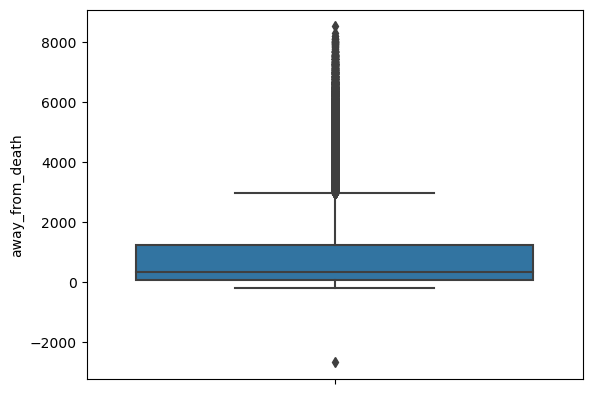

In [33]:
sns.boxplot(data= tidy_dataset, y ='away_from_death')

In [34]:
print(len(tidy_dataset[tidy_dataset["away_from_death"] < 900]))
print(len(tidy_dataset[tidy_dataset["away_from_death"] > 900]))

41956
19027


In [35]:
tidy_dataset['died_within_900days'] = [0] * len(tidy_dataset)

def age_category(data):
    data.loc[(data['away_from_death'] < 900), 'died_within_900days'] = 1
    data.loc[(data['away_from_death'] >= 900), 'died_within_900days'] = 0
    data.loc[(data['away_from_death'].isna()), 'died_within_900days'] = 0
    return data
tidy_dataset = age_category(tidy_dataset)
tidy_dataset

,Internalpatientid,num_stays,stay_length,num_unique_units,num_transfers,num_cvd_readmission,Died,AO,CVD,unique_admitting_specialty,...,Others_Specialty,Rehab,Gerontology,next_readmission_time,Discharge date,readmission within 300 days,Age at death,Death date,away_from_death,died_within_900days
0,1,3,14.16,2,0,0,0,0,0,3,...,0,0,0,2352.34,2016-07-22 21:36:24,0,NaN,NaT,NaN,0
1,2,21,71.17,5,2,9,0,0,1,9,...,0,9,1,0.00,2023-09-12 02:28:10,0,NaN,NaT,NaN,0
2,3,1,1.83,1,0,0,0,0,1,1,...,0,1,0,885.57,2002-03-30 18:12:14,0,82.284691,2005-10-12 01:18:21,1291.0,0
3,4,1,7.15,1,0,0,0,0,1,1,...,0,1,0,0.00,2015-02-23 09:46:15,0,84.190359,2015-02-24 13:49:53,1.0,1
4,5,1,1.04,1,0,0,0,0,1,1,...,0,0,0,26.75,2004-10-02 06:54:56,1,76.506124,2004-11-04 23:43:20,33.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84531,169055,1,6.47,1,0,0,0,0,1,1,...,0,0,0,0.00,2002-04-12 16:51:53,0,68.572433,2011-12-06 05:22:50,3524.0,0
84532,169057,28,94.63,3,2,12,0,0,1,11,...,0,13,12,2.21,2025-02-12 17:23:04,1,NaN,NaT,NaN,0
84533,169060,7,41.68,2,0,4,0,0,1,5,...,0,1,1,51.81,2017-02-08 09:55:03,1,71.832486,2017-10-15 18:34:11,249.0,1
84534,169062,11,135.67,4,0,0,0,1,0,6,...,0,0,0,89.89,2005-06-04 03:34:07,1,74.181399,2005-10-14 07:13:53,132.0,1


In [36]:
print(len(tidy_dataset[tidy_dataset["died_within_900days"] == 0]))
print(len(tidy_dataset[tidy_dataset["died_within_900days"] == 1]))

42580
41956


In [37]:
tidy_dataset.to_csv("inpatient_full_simple.csv")